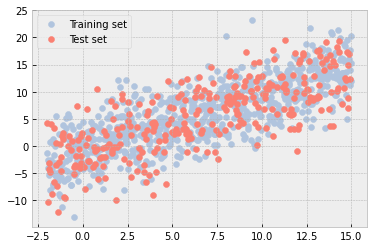

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import normal
plt.style.use('bmh')
%matplotlib inline

np.random.seed(3)

x = np.linspace(start = -2, stop=15, num=1000)
intercept, x_coef = -1, 1 
y = [x_coef*i + intercept for i in x]
y = [i+normal(0, 4) for i in y]

data = pd.DataFrame({'x': x, 'y': y})

# Split the data into training/testing sets
train, test = train_test_split(data, test_size=0.3)
X_train, X_test = train.x, test.x

# Split the targets into training/testing sets
y_train, y_test = train.y, test.y

plt.scatter(X_train, y_train, color='lightsteelblue', label = 'Training set')
plt.scatter(X_test, y_test, color='salmon', label = 'Test set')
plt.legend()

In [2]:
import mxnet as mx
from mxnet import np,gluon

batch_size=64
X_train_tensor=X_train.values.astype('float32')[:,np.newaxis]
y_train_tensor=y_train.values.astype('float32')[:,np.newaxis]
train_ds=mx.gluon.data.dataset.ArrayDataset(X_train_tensor,y_train_tensor)
train_loader=gluon.data.dataloader.DataLoader(train_ds,batch_size=batch_size,shuffle=True)

X_test_tensor=X_test.values.astype('float32')[:,np.newaxis]
y_test_tensor=y_test.values.astype('float32')[:,np.newaxis]
test_ds=mx.gluon.data.dataset.ArrayDataset(X_test_tensor,y_test_tensor)
test_loader=gluon.data.dataloader.DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [3]:
import sys
sys.path.append("../") 

In [4]:
len(train_loader)*batch_size

704

In [5]:
X_train.shape

(700,)

# No Uncertainty

In [7]:
import mxnet as mx
from mxnet import nd, autograd, gluon,np
from hamiltonian.inference.bbb import sgd
from hamiltonian.models.linear import linear

model_ctx=mx.cpu()
hyper={'alpha':np.array(10.0, ctx=model_ctx),'scale':1.}
model=linear(hyper,in_units=1,out_units=1,ctx=model_ctx)
inference=sgd(model,step_size=0.0005,ctx=model_ctx)

In [8]:
params=model.net.collect_params()

In [10]:
def softplus(x):
    return np.log(1.0 + np.exp(x))

def inv_softplus(x):
    return np.log(np.exp(x) - 1.0)

def create_variational_params(params,context):
    var_params=dict()
    for i, model_param in zip(params,params.values()):

        var_mu = gluon.Parameter(
            'var_mu_{}'.format(i), shape=model_param.shape,
            init=mx.init.Normal(0.))
        var_mu.initialize(ctx=context)
        var_params.update({'var_mu_{}'.format(i):var_mu})

        var_rho = gluon.Parameter(
            'var_rho_{}'.format(i), shape=model_param.shape,
            init=mx.init.Constant(inv_softplus(1.)))
        var_rho.initialize(ctx=context)
        var_params.update({'var_rho_{}'.format(i):var_rho})
    return var_params

In [11]:
import mxnet.gluon.probability as mxp

def sample_params(params,var_params):
    for i,model_param in zip(params,params.values()):
        epsilon=mx.np.random.normal(size=model_param.shape,loc=0.,scale=1.)
        var_sigma=softplus(var_params['var_rho_{}'.format(i)].data())
        param_data= var_params['var_mu_{}'.format(i)].data() + var_sigma * epsilon
        model_param.set_data(param_data)
    return params

In [12]:
params=model.net.collect_params()
var_params=create_variational_params(model.net.collect_params(),mx.cpu())

In [14]:
for par in params.values():
    par.grad_req='null'

In [22]:
trainer=gluon.Trainer(var_params, 'sgd', {'learning_rate': 0.005})
history=list()
for X,y in train_loader:
    X=mx.np.array(X)
    y=mx.np.array(y)
    with autograd.record():
        sampled_params=sample_params(params,var_params)
        loss=model.loss(sampled_params,X_train=X,y_train=y)
    loss.backward()
    trainer.step(batch_size)
    history.append(loss.asnumpy())
    print(loss)

[819.3722]
[606.69794]
[861.97455]
[919.765]
[659.5462]
[402.234]
[698.40027]
[912.98785]
[544.6613]
[712.9822]
[438.6644]


In [16]:
loss

array([1152.1742])

In [1]:
loss

NameError: name 'loss' is not defined

In [8]:
train_sgd=True
num_epochs=1000
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,
                           data_loader=train_loader,chain_name='linear_map.h5',verbose=True)

iteration 0, train loss: 1170.1803, train accuracy : 0.0871
iteration 100, train loss: 496.7298, train accuracy : 0.1216
iteration 200, train loss: 543.2988, train accuracy : 0.1222
iteration 300, train loss: 572.4665, train accuracy : 0.1216
iteration 400, train loss: 347.5391, train accuracy : 0.1206
iteration 500, train loss: 487.7392, train accuracy : 0.1195
iteration 600, train loss: 578.6428, train accuracy : 0.1185
iteration 700, train loss: 642.4195, train accuracy : 0.1178
iteration 800, train loss: 524.0192, train accuracy : 0.1172
iteration 900, train loss: 623.7101, train accuracy : 0.1168


In [9]:

[par.data() for par in  model.net.collect_params().values()]

[array([[1.0008366]]), array([-0.8046753])]

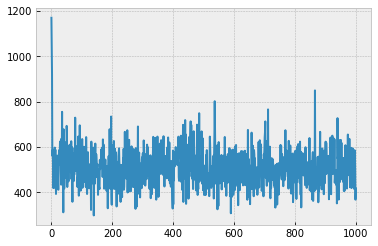

In [10]:
plt.plot(loss)

In [11]:
params={var:theta.data() for var,theta in  zip(par,par.values())}

In [12]:
total_samples,total_labels,total_loglike=inference.predict(params,num_samples=100,data_loader=test_loader)

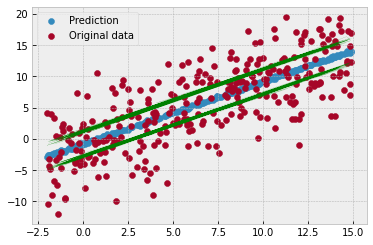

In [13]:
plt.scatter(X_test_tensor, total_samples.mean(axis=0), label = 'Prediction')
plt.plot(X_test,total_samples.mean(axis=0)+2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.plot(X_test,total_samples.mean(axis=0)-2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

# Aleatoric Uncertainty

In [14]:
import mxnet as mx
from mxnet import nd, autograd, gluon,np
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.linear import linear_aleatoric

model_ctx=mx.cpu()
hyper={'alpha':np.array(10.0, ctx=model_ctx)}
model=linear_aleatoric(hyper,in_units=1,out_units=1,ctx=model_ctx)
inference=sgd(model,step_size=0.001,ctx=model_ctx)

In [15]:
train_sgd=True
num_epochs=1000
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,
                           data_loader=train_loader,chain_name='linear_aleatoric_map.h5',verbose=True)

iteration 0, train loss: 936.9587, train accuracy : 0.0914
iteration 100, train loss: 609.8436, train accuracy : 0.1205
iteration 200, train loss: 379.8757, train accuracy : 0.1175
iteration 300, train loss: 437.9142, train accuracy : 0.1165
iteration 400, train loss: 336.0398, train accuracy : 0.1157
iteration 500, train loss: 442.2900, train accuracy : 0.1152
iteration 600, train loss: 269.1439, train accuracy : 0.1147
iteration 700, train loss: 248.5822, train accuracy : 0.1142
iteration 800, train loss: 399.4169, train accuracy : 0.1138
iteration 900, train loss: 298.0707, train accuracy : 0.1134


In [16]:
params={var:theta.data() for var,theta in  zip(par,par.values())}
total_samples,total_labels,total_loglike=inference.predict(params,num_samples=100,data_loader=test_loader)

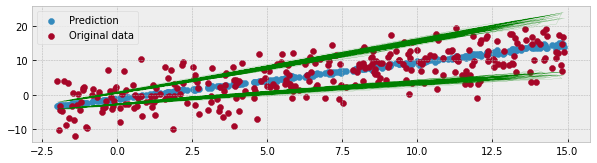

In [17]:
plt.figure(figsize=[10, 2.5])  # inches
plt.scatter(X_test_tensor, total_samples.mean(axis=0), label = 'Prediction')
plt.plot(X_test_tensor,total_samples.mean(axis=0)+2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.plot(X_test_tensor,total_samples.mean(axis=0)-2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

In [18]:
y_hat=model.predict(model.net.collect_params(),mx.np.array(X_test_tensor))

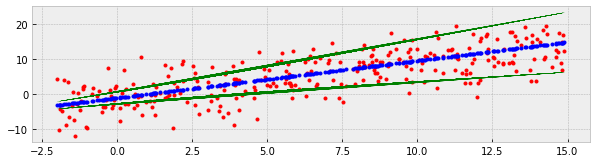

In [19]:
plt.figure(figsize=[10, 2.5])  # inches
plt.plot(X_test, y_test, 'r.', label='observed');

m = y_hat.mean
s = y_hat.stddev

plt.plot(X_test, m, 'b.', linewidth=4, label='mean');
plt.plot(X_test, m + 2 * s, 'g', linewidth=.2, label=r'mean + 2 stddev');
plt.plot(X_test, m - 2 * s, 'g', linewidth=.2, label=r'mean - 2 stddev');




# Epistemic Uncertainty

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon,np
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.linear import linear_aleatoric

model_ctx=mx.cpu()
hyper={'alpha':np.array(10.0, ctx=model_ctx),'scale':1.}
model=linear(hyper,in_units=1,out_units=1,ctx=model_ctx)
inference=sgld(model,step_size=0.001,ctx=model_ctx)

NameError: name 'linear' is not defined

In [21]:
train_sgld=True
num_epochs=1000
if train_sgld:
    par,loss=inference.sample(epochs=num_epochs,batch_size=batch_size,chains=2,
                           data_loader=train_loader,chain_name='linear_epistemic_map.h5',verbose=True)

iteration 0, train loss: 27.9463, train accuracy : 0.0771
iteration 100, train loss: 8.6086, train accuracy : 0.1065
iteration 200, train loss: 9.3233, train accuracy : 0.1050
iteration 300, train loss: 9.3421, train accuracy : 0.1059
iteration 400, train loss: 9.1576, train accuracy : 0.1077
iteration 500, train loss: 8.5796, train accuracy : 0.1081
iteration 600, train loss: 9.4203, train accuracy : 0.1078
iteration 700, train loss: 8.6227, train accuracy : 0.1080
iteration 800, train loss: 10.7565, train accuracy : 0.1082
iteration 900, train loss: 10.6857, train accuracy : 0.1085
iteration 0, train loss: 8.4335, train accuracy : 0.1100
iteration 100, train loss: 8.4347, train accuracy : 0.1108
iteration 200, train loss: 8.4474, train accuracy : 0.1101
iteration 300, train loss: 8.4531, train accuracy : 0.1098
iteration 400, train loss: 8.4730, train accuracy : 0.1097
iteration 500, train loss: 8.4605, train accuracy : 0.1095
iteration 600, train loss: 8.4558, train accuracy : 0.109

In [22]:
import h5py

params=h5py.File('linear_epistemic_map.h5','r')
total_samples,total_labels,total_loglike=inference.predict(params,num_samples=100,data_loader=test_loader)

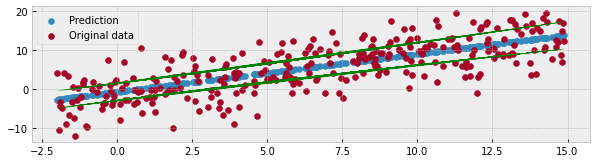

In [23]:
plt.figure(figsize=[10, 2.5])  # inches
plt.scatter(X_test_tensor, total_samples.mean(axis=0), label = 'Prediction')
plt.plot(X_test_tensor,total_samples.mean(axis=0)+2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.plot(X_test_tensor,total_samples.mean(axis=0)-2*total_samples.std(axis=0),'g',linewidth=0.1)
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

# Bayes by backprop

In [7]:
import mxnet as mx
from mxnet import nd, autograd, gluon,np
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.linear import linear

model_ctx=mx.cpu()
hyper={'alpha':np.array(10.0, ctx=model_ctx),'scale':1.}
model=linear(hyper,in_units=1,out_units=1,ctx=model_ctx)
inference=bbb(model,step_size=0.001,ctx=model_ctx)

In [8]:
train_sgld=True
num_epochs=1000
if train_sgld:
    par,loss,var_params=inference.fit(epochs=num_epochs,batch_size=batch_size,
                           data_loader=train_loader,chain_name='linear_bbb_map.h5',verbose=True)

loss: 152.2886
loss: 50.1197
loss: 84.6419
loss: 59.0327
loss: 42.3804
loss: 35.4606
loss: 36.1670
loss: 63.6787
loss: 31.6207
loss: 27.4121
loss: 35.4984
loss: 46.6112
loss: 33.8603
loss: 24.5395
loss: 38.1883
loss: 33.3813
loss: 40.7935
loss: 28.4278
loss: 25.3880
loss: 15.6503
loss: 15.5480
loss: 21.0403
loss: 18.7500
loss: 12.8082
loss: 38.7380
loss: 16.9566
loss: 19.8338
loss: 20.5889
loss: 21.4144
loss: 17.7199
loss: 26.7689
loss: 21.1319
loss: 22.8607
loss: 13.7058
loss: 15.5436
loss: 25.8470
loss: 14.1153
loss: 14.3668
loss: 18.3077
loss: 14.5997
loss: 18.6494
loss: 20.1651
loss: 16.2503
loss: 18.5249
loss: 16.8870
loss: 15.7184
loss: 17.4880
loss: 17.4254
loss: 20.4589
loss: 16.9866
loss: 12.7322
loss: 12.7686
loss: 13.6963
loss: 12.0748
loss: 17.7224
loss: 17.5324
loss: 14.5964
loss: 18.2267
loss: 21.5933
loss: 15.9085
loss: 15.8232
loss: 14.2286
loss: 15.5141
loss: 16.1374
loss: 12.1325
loss: 14.2274
loss: 12.4357
loss: 9.6966
loss: 11.3760
loss: 13.7055
loss: 13.9199
loss: 

KeyError: 'var_mu_0.weight'